# Evaluating a PyCon Assistant Copilot using Azure AI Evaluation SDK

This notebook demonstrates how to evaluate a custom copilot that acts as a PyCon conference assistant using the Azure AI Evaluation SDK. We'll set up evaluation datasets, define custom evaluation criteria, and analyze the assistant's responses for quality, relevance, and helpfulness in the context of Python conference information.

## Installation

First, let's install the required packages:

In [12]:
# Install the Azure AI Evaluation SDK and other required packages
!pip install azure-ai-evaluation azure-identity openai azure_ai_projects

## Setup and Configuration

Let's set up our environment variables and authentication for Azure services:

In [13]:
import os
import json
from azure.identity import DefaultAzureCredential
from openai import AzureOpenAI

# Load environment variables from .env file
try:
    from dotenv import load_dotenv
    # Load .env file if it exists
    load_dotenv()
    print("✅ Loaded environment variables from .env file")
except ImportError:
    print("⚠️ python-dotenv not installed. Install with: pip install python-dotenv")
    print("  Using environment variables directly from system.")

# Set up authentication - prefer DefaultAzureCredential for managed identity support
credential = DefaultAzureCredential()

# Initialize Azure AI project configuration
azure_ai_project = {
    "subscription_id": os.getenv("AZURE_SUBSCRIPTION_ID"),
    "resource_group_name": os.getenv("AZURE_RESOURCE_GROUP"),
    "project_name": os.getenv("AZURE_PROJECT_NAME"),
}

# Model configuration for evaluators that use LLMs
model_config = {
    "azure_endpoint": os.getenv("AZURE_OPENAI_ENDPOINT"),
    "api_key": os.getenv("AZURE_OPENAI_API_KEY"),
    "api_version": os.getenv("AZURE_OPENAI_API_VERSION", "2023-12-01-preview"),
    "azure_deployment": os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME")
}

# Validate configuration
missing_vars = []
for config_dict, keys in [
    (azure_ai_project, ["subscription_id", "resource_group_name", "project_name"]),
    (model_config, ["azure_endpoint", "api_key", "api_version", "azure_deployment"]),
]:
    for key in keys:
        if not config_dict.get(key):
            missing_vars.append(key)

if missing_vars:
    print(f"❌ Missing required environment variables: {', '.join(missing_vars)}")
    print("Please set these environment variables before running the notebook.")
    print("You can run setup_env.py to create a .env file with these variables.")
else:
    print("✅ All required environment variables are set!")

# Initialize Azure OpenAI client for our assistant simulation
try:
    client = AzureOpenAI(
        azure_endpoint=model_config["azure_endpoint"],
        api_key=model_config["api_key"],
        api_version=model_config["api_version"]
    )
    print("✅ Successfully initialized Azure OpenAI client")
except Exception as e:
    print(f"❌ Failed to initialize Azure OpenAI client: {str(e)}")
    print("Please check your environment variables and Azure OpenAI configuration.")

✅ Loaded environment variables from .env file
✅ All required environment variables are set!
✅ Successfully initialized Azure OpenAI client
✅ Successfully initialized Azure OpenAI client


## Define PyCon Assistant System Prompt

Here we'll define the system prompt that turns a general LLM into a PyCon conference assistant:

In [14]:
PYCON_ASSISTANT_SYSTEM_PROMPT = """
You are a helpful PyCon conference assistant. Your primary role is to assist conference attendees 
with information about the conference schedule, talks, workshops, speakers, and logistics. 

You have the following knowledge about PyCon 2025:
- The conference is happening May 15-23, 2025 in Pittsburgh, PA
- Main conference days are May 17-19, with tutorials on May 15-16 and sprints on May 20-23
- Registration opens December 15, 2024 with early bird pricing until February 1, 2025
- The venue is the David L. Lawrence Convention Center in downtown Pittsburgh
- Keynote speakers include Guido van Rossum, Dr. Russell Keith-Magee, and Dr. Łukasz Langa
- There are 95 scheduled talks across 5 parallel tracks, 30 tutorials, and 15 sponsored workshops
- Conference themes include: AI/ML, Web Development, Data Science, Python Core, and Python in Education

Important policies include:
- All attendees must follow the conference Code of Conduct
- Refunds available up to 30 days before the conference with a 10% processing fee
- Limited financial aid is available through an application process that closes February 28, 2025

Answer questions helpfully, accurately, and concisely. If you don't know an answer, acknowledge that 
and suggest where the attendee might find the information (e.g., the registration desk, conference website, etc.).
"""

## Create a PyCon Assistant Simulation

We'll create a function that simulates our PyCon assistant by using the Azure OpenAI service with our system prompt:

In [15]:
def pycon_assistant(query):
    """Simulate a PyCon assistant by using Azure OpenAI with a specific system prompt"""
    try:
        response = client.chat.completions.create(
            model=model_config["azure_deployment"],
            messages=[
                {"role": "system", "content": PYCON_ASSISTANT_SYSTEM_PROMPT},
                {"role": "user", "content": query}
            ],
            temperature=0.3,  # Lower temperature for more consistent answers
            max_tokens=500
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error in pycon_assistant: {e}")
        return f"Sorry, I encountered an error: {str(e)}"

## Create PyCon-Specific Test Dataset

Now, let's create a dataset of PyCon-specific questions that we'll use to evaluate our assistant:

In [16]:
# Create test dataset with questions, relevant context, and expected answer patterns
pycon_test_data = [
    {
        "query": "When is PyCon 2025 happening?",
        "context": "The conference is happening May 15-23, 2025 in Pittsburgh, PA.",
        "expected_pattern": "May 15-23, 2025",
        "category": "logistics"
    },
    {
        "query": "Who are the keynote speakers?",
        "context": "Keynote speakers include Guido van Rossum, Dr. Russell Keith-Magee, and Dr. Łukasz Langa.",
        "expected_pattern": "Guido van Rossum|Russell Keith-Magee|Łukasz Langa",
        "category": "speakers"
    },
    {
        "query": "How much does registration cost?",
        "context": "Registration opens December 15, 2024 with early bird pricing until February 1, 2025.",
        "expected_pattern": "",  # No specific pricing was provided in system prompt
        "category": "registration"
    },
    {
        "query": "Do you have a code of conduct?",
        "context": "All attendees must follow the conference Code of Conduct.",
        "expected_pattern": "Code of Conduct",
        "category": "policy"
    },
    {
        "query": "Can I get a refund if I can't attend?",
        "context": "Refunds available up to 30 days before the conference with a 10% processing fee.",
        "expected_pattern": "30 days|10%",
        "category": "policy"
    },
    {
        "query": "How many tracks will the conference have?",
        "context": "There are 95 scheduled talks across 5 parallel tracks, 30 tutorials, and 15 sponsored workshops.",
        "expected_pattern": "5 parallel tracks|5 tracks",
        "category": "schedule"
    },
    {
        "query": "What topics will be covered at PyCon 2025?",
        "context": "Conference themes include: AI/ML, Web Development, Data Science, Python Core, and Python in Education.",
        "expected_pattern": "AI/ML|Web Development|Data Science|Python Core|Python in Education",
        "category": "content"
    },
    {
        "query": "Is there financial aid available?",
        "context": "Limited financial aid is available through an application process that closes February 28, 2025.",
        "expected_pattern": "financial aid|application|February 28",
        "category": "logistics"
    },
    {
        "query": "Where exactly is the conference venue located?",
        "context": "The venue is the David L. Lawrence Convention Center in downtown Pittsburgh.",
        "expected_pattern": "David L. Lawrence Convention Center|downtown Pittsburgh",
        "category": "logistics"
    },
    {
        "query": "When do the tutorial sessions happen?",
        "context": "Main conference days are May 17-19, with tutorials on May 15-16 and sprints on May 20-23.",
        "expected_pattern": "May 15-16",
        "category": "schedule"
    }
]

# Generate responses from our PyCon assistant
for item in pycon_test_data:
    item["response"] = pycon_assistant(item["query"])

# Save the sample data to a JSONL file
with open("pycon_test_data.jsonl", "w") as f:
    for item in pycon_test_data:
        f.write(json.dumps(item) + "\n")

# Display a few examples of the assistant's responses
for i in range(3):  # Show first 3 examples
    print(f"Query: {pycon_test_data[i]['query']}")
    print(f"Response: {pycon_test_data[i]['response']}")
    print("---")

Query: When is PyCon 2025 happening?
Response: PyCon 2025 is happening from May 15-23, 2025. The main conference days are May 17-19, with tutorials on May 15-16 and sprints on May 20-23.
---
Query: Who are the keynote speakers?
Response: The keynote speakers for PyCon 2025 are Guido van Rossum, Dr. Russell Keith-Magee, and Dr. Łukasz Langa.
---
Query: How much does registration cost?
Response: I don't have the exact registration costs for PyCon 2025. However, you can find detailed pricing information on the PyCon conference website or by contacting the registration desk. Remember, early bird pricing is available until February 1, 2025, which might offer a discount.
---


## Create Custom Evaluators for PyCon Assistant

Now, let's create some custom evaluators specifically designed to evaluate a conference assistant:

In [ ]:
import re
from azure.ai.evaluation import (
    GroundednessEvaluator,
    RelevanceEvaluator,
    CoherenceEvaluator,
    FluencyEvaluator
)

# Initialize built-in evaluators
groundedness_eval = GroundednessEvaluator(model_config)
relevance_eval = RelevanceEvaluator(model_config)
coherence_eval = CoherenceEvaluator(model_config)
fluency_eval = FluencyEvaluator(model_config)


## Run Evaluation on the Test Dataset

Now let's evaluate our PyCon assistant using both built-in and custom evaluators:

In [ ]:
from azure.ai.evaluation import evaluate


# Run the evaluation on our test dataset
result = evaluate(
    data="pycon_test_data.jsonl",  # path to the data file
    evaluators={
        "groundedness": groundedness_eval,
        "relevance": relevance_eval,
        "coherence": coherence_eval,
        "fluency": fluency_eval,
        # "conference_assistant": conference_assistant_eval
    },
    # Column mapping to tell the evaluator which columns to use
    evaluator_config={
        "groundedness": {
            "column_mapping": {
                "query": "${data.query}",
                "context": "${data.context}",
                "response": "${data.response}"
            }
        },
        "relevance": {
            "column_mapping": {
                "query": "${data.query}",
                "response": "${data.response}"
            }
        },
        "coherence": {
            "column_mapping": {
                "query": "${data.query}",
                "response": "${data.response}"
            }
        },
        "fluency": {
            "column_mapping": {
                "response": "${data.response}"
            }
        },
    },
    # Output path to save results
    output_path="./pycon_assistant_evaluation_results.json"
)

# Print evaluation results
print("Aggregate Metrics:")
print(json.dumps(result["metrics"], indent=2))
print("\nRow-level Results (first row):")
print(json.dumps(result["rows"][0], indent=2))

[2025-04-29 14:04:31 -0700][promptflow._core.entry_meta_generator][WARNING] - Generate meta in current process and timeout won't take effect. Please handle timeout manually outside current process.
[2025-04-29 14:04:31 -0700][promptflow._sdk._orchestrator.run_submitter][INFO] - Submitting run azure_ai_evaluation_evaluators_groundedness_20250429_140431_461052, log path: /home/llawrence/.promptflow/.runs/azure_ai_evaluation_evaluators_groundedness_20250429_140431_461052/logs.txt


[2025-04-29 14:04:31 -0700][promptflow._core.entry_meta_generator][WARNING] - Generate meta in current process and timeout won't take effect. Please handle timeout manually outside current process.
[2025-04-29 14:04:31 -0700][promptflow._sdk._orchestrator.run_submitter][INFO] - Submitting run azure_ai_evaluation_evaluators_groundedness_20250429_140431_461052, log path: /home/llawrence/.promptflow/.runs/azure_ai_evaluation_evaluators_groundedness_20250429_140431_461052/logs.txt


2025-04-29 14:04:31 -0700  447238 execution.bulk     INFO     Current thread is not main thread, skip signal handler registration in BatchEngine.
2025-04-29 14:04:34 -0700  447238 execution.bulk     INFO     Finished 1 / 10 lines.
2025-04-29 14:04:34 -0700  447238 execution.bulk     INFO     Average execution time for completed lines: 2.89 seconds. Estimated time for incomplete lines: 26.01 seconds.
2025-04-29 14:04:34 -0700  447238 execution.bulk     INFO     Finished 2 / 10 lines.
2025-04-29 14:04:34 -0700  447238 execution.bulk     INFO     Average execution time for completed lines: 1.47 seconds. Estimated time for incomplete lines: 11.76 seconds.
2025-04-29 14:04:34 -0700  447238 execution.bulk     INFO     Finished 3 / 10 lines.
2025-04-29 14:04:34 -0700  447238 execution.bulk     INFO     Average execution time for completed lines: 1.05 seconds. Estimated time for incomplete lines: 7.35 seconds.
2025-04-29 14:04:34 -0700  447238 execution.bulk     INFO     Finished 5 / 10 lines.

## Analyze the Evaluation Results

Let's analyze the evaluation results to identify strengths and areas for improvement:

,query,category,groundedness,relevance,coherence,fluency
0,When is PyCon 2025 happening?,logistics,3,5,4,4
1,Who are the keynote speakers?,speakers,3,4,4,3
2,How much does registration cost?,registration,3,3,4,4
3,Do you have a code of conduct?,policy,3,5,4,4
4,Can I get a refund if I can't attend?,policy,3,5,4,4
5,How many tracks will the conference have?,schedule,4,4,4,3
6,What topics will be covered at PyCon 2025?,content,3,5,4,4
7,Is there financial aid available?,logistics,3,5,4,4
8,Where exactly is the conference venue located?,logistics,5,4,4,3
9,When do the tutorial sessions happen?,schedule,4,4,4,3


<Figure size 1200x600 with 0 Axes>

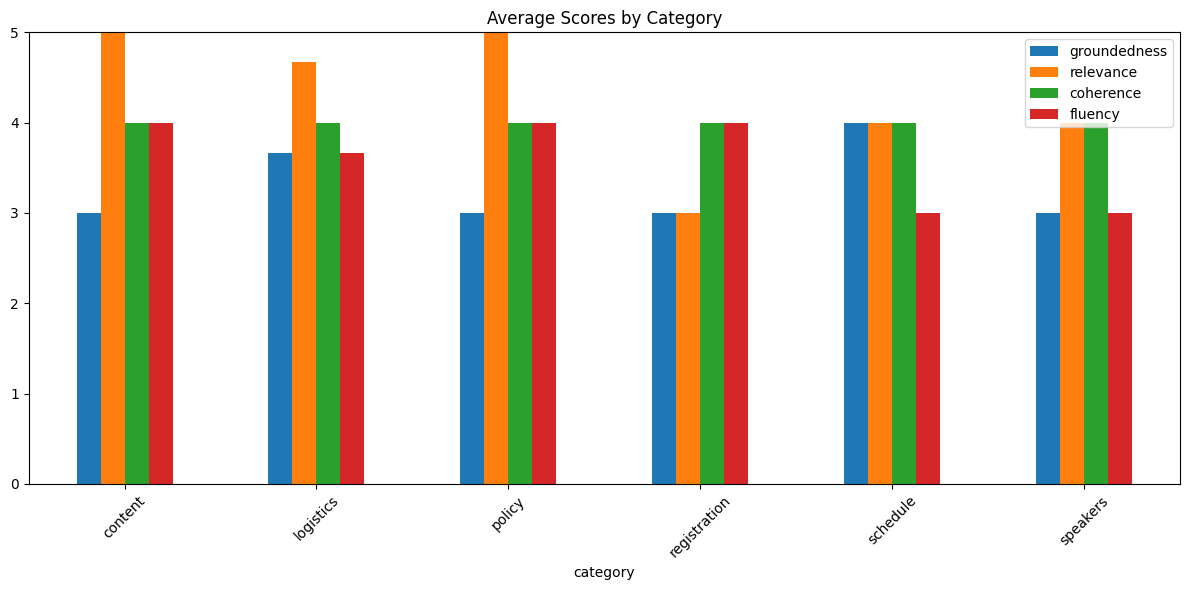

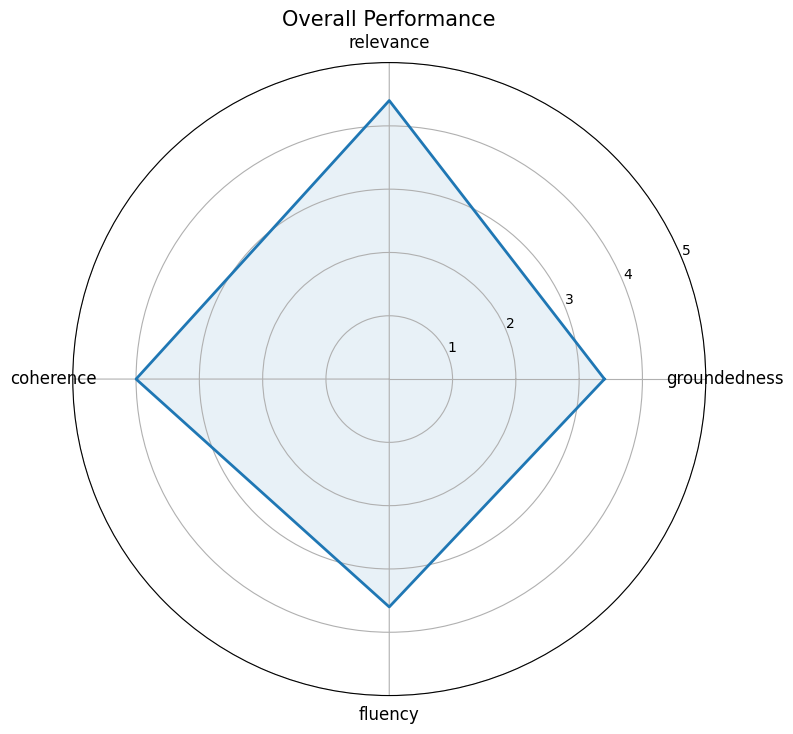

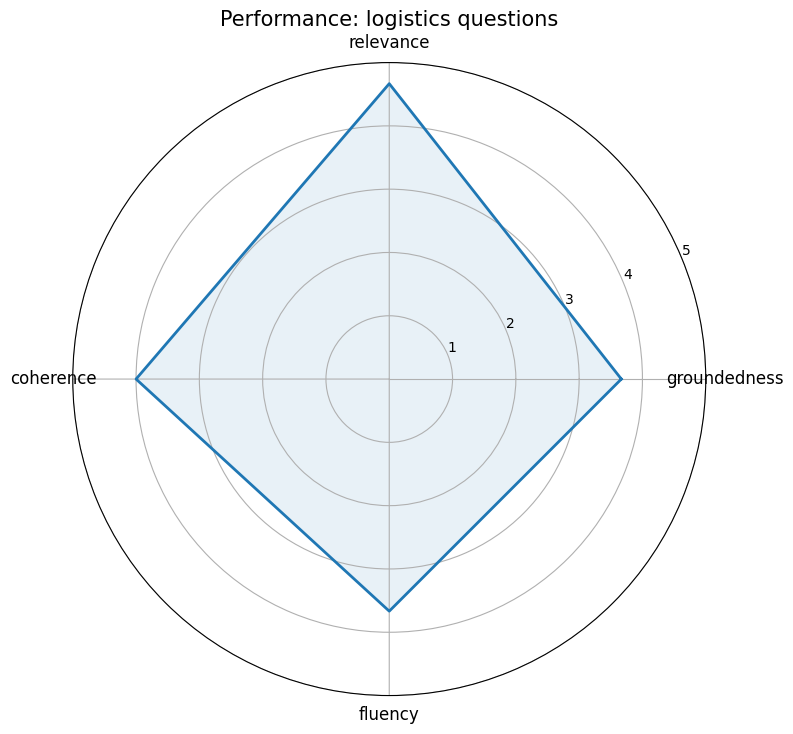

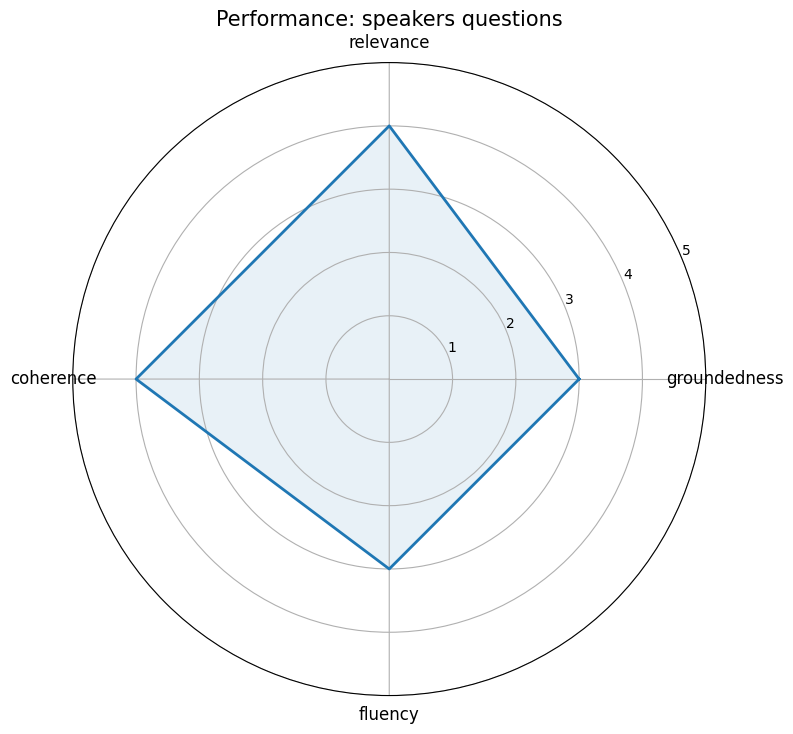

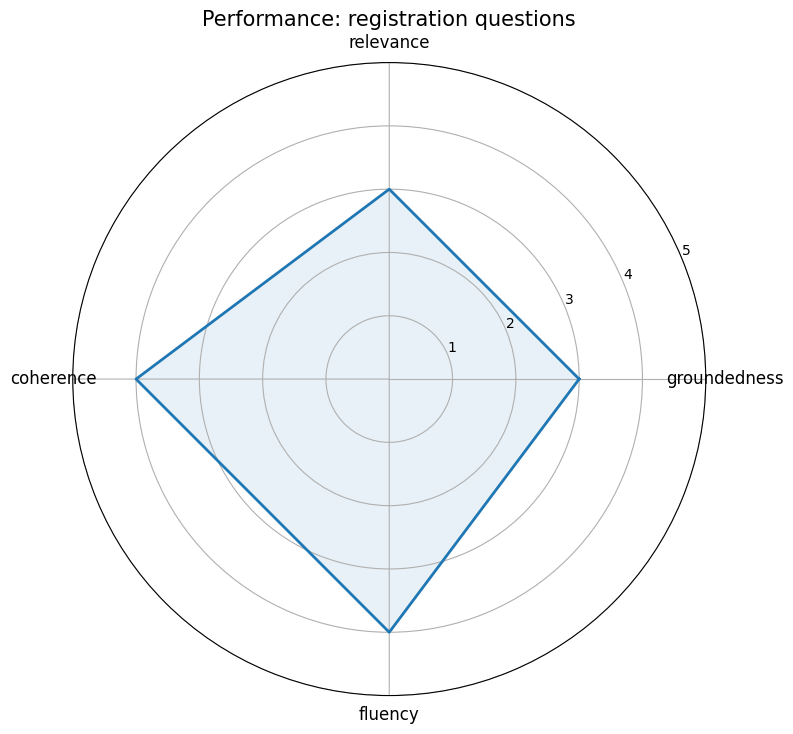

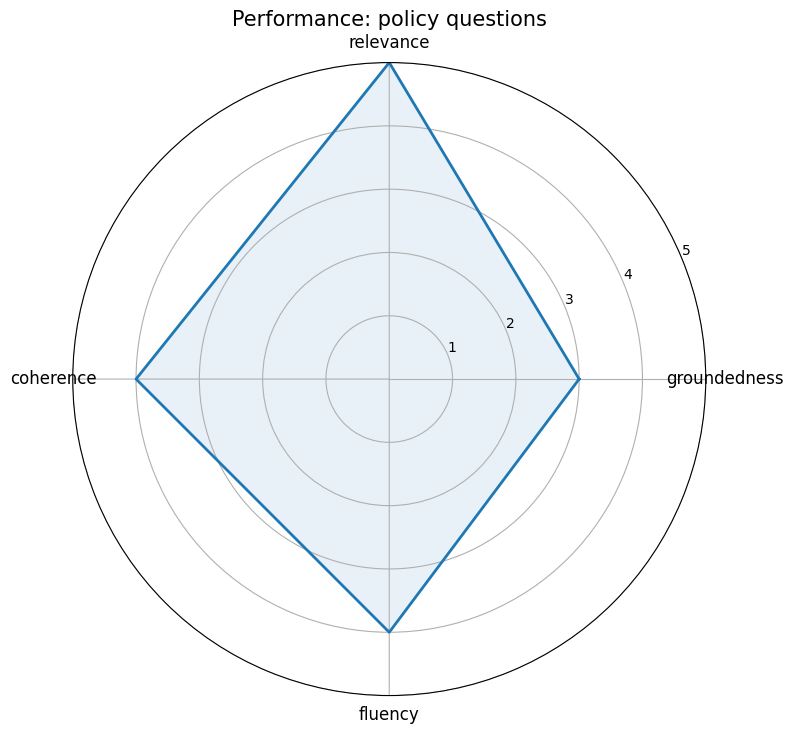

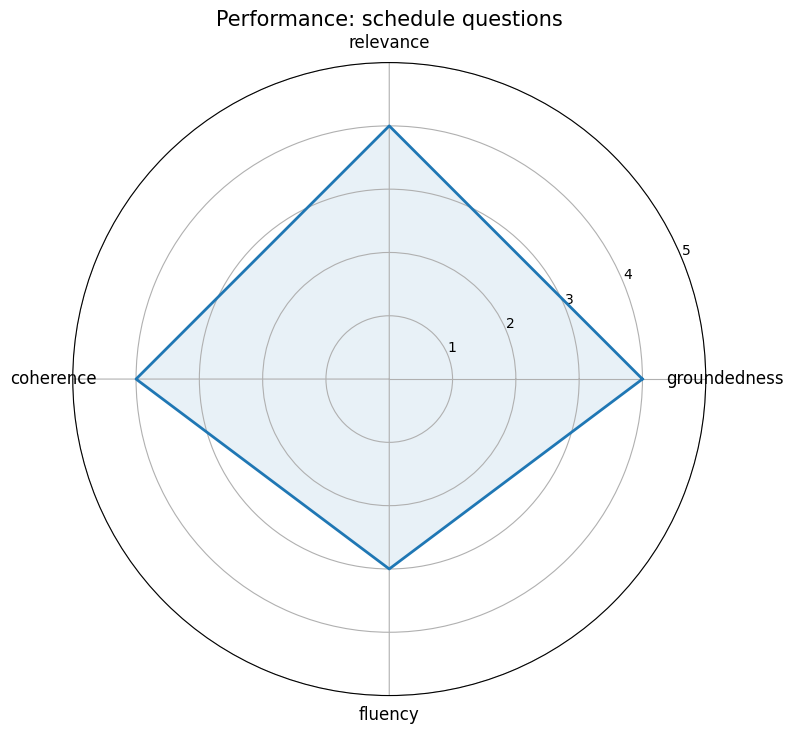

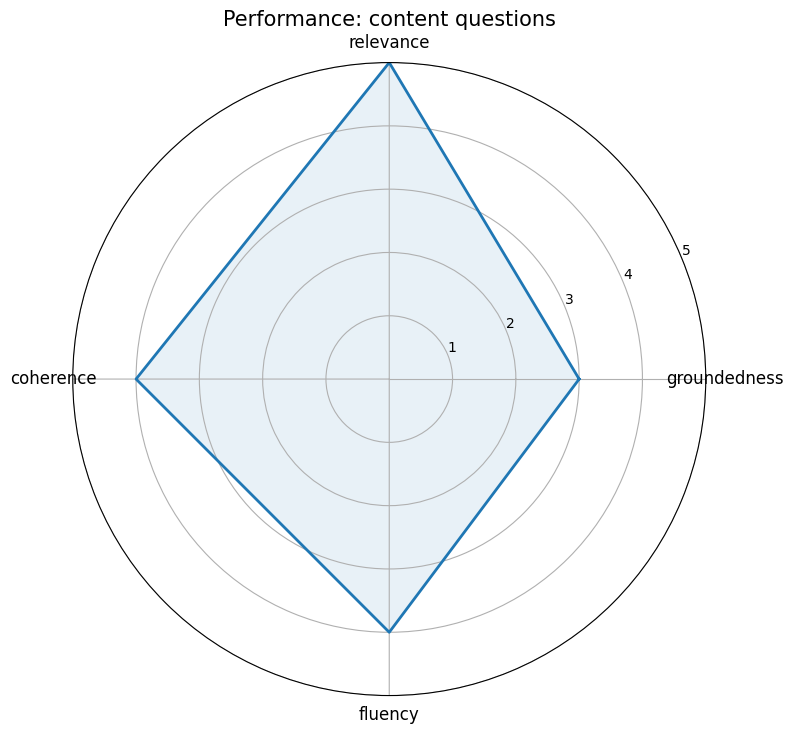

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the evaluation results
with open("pycon_assistant_evaluation_results.json", "r") as f:
    eval_results = json.load(f)

# Create a DataFrame from the row-level results
rows_data = []
for row in eval_results["rows"]:
    row_data = {
        "query": row["inputs.query"],
        "category": row["inputs.category"],
        "groundedness": row["outputs.groundedness.groundedness"],
        "relevance": row["outputs.relevance.relevance"],
        "coherence": row["outputs.coherence.coherence"],
        "fluency": row["outputs.fluency.fluency"],
    }
    
    rows_data.append(row_data)

df = pd.DataFrame(rows_data)

# Display the DataFrame
print("Evaluation Results by Query:")
display(df)

# Create visualizations to analyze results
plt.figure(figsize=(12, 6))

# Only select numeric columns for mean calculation
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

# Overall metrics by category 
category_scores = df.groupby('category')[numeric_cols].mean()
category_scores.plot(kind='bar', figsize=(12, 6), title='Average Scores by Category')
plt.xticks(rotation=45)
plt.ylim(0, 5)  # Assuming scores are on a 0-5 scale
plt.tight_layout()
plt.show()

# Create radar charts for each category
categories = df['category'].unique()
metrics = [m for m in ['groundedness', 'relevance', 'coherence', 'fluency', 'helpfulness', 'friendliness', 'conciseness', 'accuracy'] 
          if m in numeric_cols]

# Function to create a radar chart
def create_radar_chart(category_data, title):
    # Number of variables
    N = len(metrics)
    
    # What will be the angle of each axis in the plot (divide the plot / number of variables)
    angles = [n / float(N) * 2 * 3.14159 for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Get the values
    values = category_data[metrics].mean().values.flatten().tolist()
    values += values[:1]  # Close the loop
    
    # Create the plot
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    
    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], metrics, size=12)
    
    # Draw the chart
    ax.plot(angles, values, linewidth=2, linestyle='solid')
    ax.fill(angles, values, alpha=0.1)
    
    # Set y-axis limits
    plt.ylim(0, 5)
    
    # Add title
    plt.title(title, size=15)
    
    return fig

# Create radar charts for overall and each category
create_radar_chart(df, 'Overall Performance')
plt.tight_layout()
plt.show()

for category in categories:
    category_data = df[df['category'] == category]
    create_radar_chart(category_data, f'Performance: {category} questions')
    plt.tight_layout()
    plt.show()

## Generate Insights and Recommendations

Based on the evaluation results, let's generate insights and recommendations for improving the PyCon assistant:

In [43]:
import sys
# Generate insights using Azure OpenAI
def generate_insights(eval_results, metrics_df):
    try:
        # Format the data for analysis
        metrics_str = metrics_df.to_string()
        aggregate = json.dumps(eval_results["metrics"], indent=2)
        
        insight_prompt = f"""
        You are an expert in analyzing AI assistant evaluation results. Please analyze the following evaluation 
        results for a PyCon conference assistant and provide insights and recommendations.
        
        Evaluation Metrics by Query:
        {metrics_str}
        
        Aggregate Metrics:
        {aggregate}
        
        Please provide:
        1. Key strengths (3-5 bullet points)
        2. Areas for improvement (3-5 bullet points)
        3. Specific recommendations to enhance the assistant's performance
        4. Any patterns you notice across different question categories
        
        Format your response in Markdown with clear sections and bullet points.
        """
        
        response = client.chat.completions.create(
            model=model_config["azure_deployment"],
            messages=[{"role": "user", "content": insight_prompt}],
            temperature=0.3,
            max_tokens=1000
        )
        
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error generating insights: {e}")
        return "Error generating insights. Please check the evaluation results manually."

# Generate and display insights
insights = generate_insights(eval_results, df)
insights.split("\n")

['# Analysis of PyCon Conference Assistant Evaluation Results',
 '',
 '## Key Strengths',
 "- **Relevance**: The assistant consistently scores high in relevance across all queries, with an aggregate relevance score of 4.4. This indicates that the responses are generally pertinent to the user's questions.",
 '- **Coherence**: With an aggregate coherence score of 4.0, the assistant provides logically structured responses that make sense in the context of the queries.',
 '- **Policy Queries**: Queries related to policy, such as the code of conduct and refund policy, have high relevance and coherence scores, suggesting strong performance in these areas.',
 '- **Groundedness for Venue Location**: The query about the conference venue location scores a 5 in groundedness, indicating that the assistant provides highly accurate and specific information for logistical queries.',
 '',
 '## Areas for Improvement',
 '- **Groundedness**: The overall groundedness score is 3.4, which is slightly above 

## Conclusion

This notebook demonstrates how to evaluate a custom PyCon assistant copilot using the Azure AI Evaluation SDK. We've shown how to:

1. Define a PyCon-specific system prompt to create a specialized assistant
2. Create a test dataset with conference-specific questions
3. Use built-in evaluators to assess basic quality metrics (groundedness, relevance, etc.)
4. Create custom evaluators specifically designed for conference assistants
5. Run comprehensive evaluations across different question categories
6. Analyze results to identify strengths and areas for improvement
7. Generate insights and recommendations for enhancing the assistant

This evaluation framework can be extended to evaluate other types of specialized assistants by:
- Modifying the system prompt for different domains
- Creating domain-specific test datasets
- Adding custom evaluators tailored to domain requirements
- Adjusting analysis to focus on domain-specific performance metrics

The Azure AI Evaluation SDK provides a powerful and flexible framework for evaluating and improving AI assistants across various specialized domains.